# 3 Stitching images


In [1]:
import numpy as np
from PIL import Image
from src.utils import rgb2gray
import matplotlib.pyplot as plt

image_1_color = np.asarray(Image.open('data/mountain_1.jpg'), dtype=np.float32) 
image_2_color = np.asarray(Image.open('data/mountain_2.jpg'), dtype=np.float32)
image_1 = rgb2gray(image_1_color)
image_2 = rgb2gray(image_2_color)

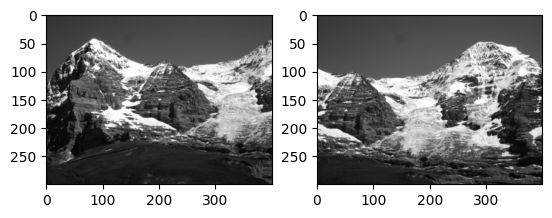

In [2]:
f, ax = plt.subplots(1,2)
ax[0].imshow(image_1, cmap='gray')
ax[1].imshow(image_2, cmap='gray')

In [3]:
# Compute corners and descriptors
from src.compute_corners import compute_corners, CornerCriterion
from src.compute_descriptors import compute_descriptors
from src.compute_matches import compute_matches


# Compute corners and descriptors for image_1
corners_1 = compute_corners(image_1, CornerCriterion.SHI_TOMASI, 0.3)
descriptors_1 = compute_descriptors(image_1, corners_1)

# Compute corners and descriptors for image_2
corners_2 = compute_corners(image_2, CornerCriterion.SHI_TOMASI, 0.3)
descriptors_2 = compute_descriptors(image_2, corners_2)

# Match descriptors
matches = compute_matches(descriptors_1, descriptors_2)

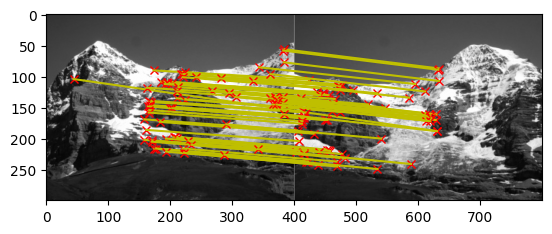

In [4]:
# Plot matches
from src.utils import plot_matches, plot_matches2

plt.figure()
plot_matches2(image_1, image_2, corners_1, corners_2, matches)

In [5]:
from src.homography import compute_homography_ransac

homography, matches, best_count = compute_homography_ransac(corners_1, corners_2, matches)

In [6]:
# Load third image
image_3_color = np.asarray(Image.open('data/mountain_3.jpg'), dtype=np.float32)
image_3 = rgb2gray(image_3_color)

# Compute corners and descriptors for image_3
corners_3 = compute_corners(image_3, CornerCriterion.SHI_TOMASI, 0.3)
descriptors_3 = compute_descriptors(image_3, corners_3)

matches_3 = compute_matches(descriptors_2, descriptors_3)

homography_3, matches_3, best_count_3 = compute_homography_ransac(corners_2, corners_3, matches_3)

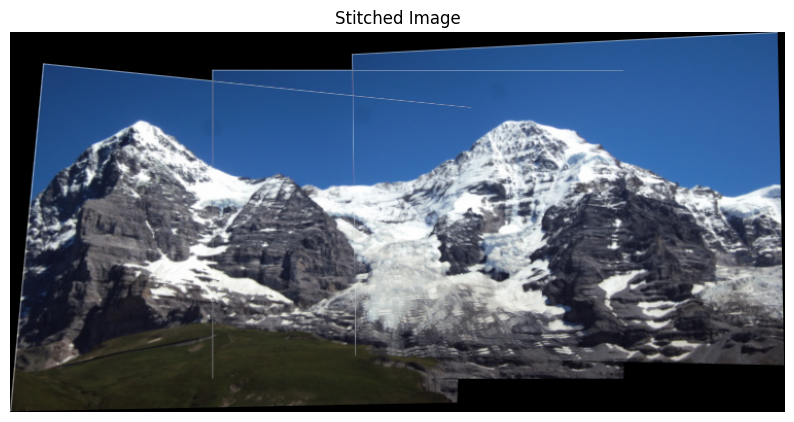

In [7]:
import cv2

def stitch_multiple_images(images, homographies, show_result=True):
    """
    Stitch multiple images (grayscale or RGB) together using their respective homographies.
    
    Each homography maps the coordinate system of the corresponding image 
    into a common coordinate system. This function computes the overall extents, 
    creates a proper canvas, warps each image accordingly, and blends them.
    
    Parameters:
    - images: List of images (numpy arrays) to be stitched. They can be grayscale (H, W)
              or RGB (H, W, 3). If using OpenCV, note that images are typically in BGR order.
    - homographies: List of 3x3 homography matrices corresponding to each image.
                    The i-th homography maps the i-th image into the common coordinate system.
    - show_result: Boolean flag to display the stitched image (default True).
    
    Returns:
    - stitched: The resulting stitched image.
    """
    if len(images) != len(homographies):
        raise ValueError("The number of images and homographies must be the same.")
    
    all_corners = []
    
    # Compute transformed corners for each image
    for img, H in zip(images, homographies):
        h, w = img.shape[:2]
        # Define image corners: top-left, top-right, bottom-right, bottom-left
        corners = np.array([[0, 0],
                            [w, 0],
                            [w, h],
                            [0, h]], dtype=np.float32)
        # Convert to homogeneous coordinates
        ones = np.ones((4, 1), dtype=np.float32)
        corners_hom = np.hstack([corners, ones])
        # Transform corners using homography
        transformed = (H @ corners_hom.T).T
        transformed = transformed / transformed[:, 2][:, None]
        all_corners.append(transformed[:, :2])
    
    # Combine all corners into one array to determine the overall extents
    all_corners = np.vstack(all_corners)
    min_x, min_y = np.min(all_corners, axis=0)
    max_x, max_y = np.max(all_corners, axis=0)
    
    # Create a translation matrix to shift all images into positive coordinate space
    translation = np.array([[1, 0, -min_x],
                            [0, 1, -min_y],
                            [0, 0, 1]], dtype=np.float32)
    
    # Compute the size of the resulting canvas
    canvas_width = int(np.ceil(max_x - min_x))
    canvas_height = int(np.ceil(max_y - min_y))
    
    # Create the canvas: if color image (3 channels) or grayscale
    if len(images[0].shape) == 3:
        channels = images[0].shape[2]
        stitched = np.zeros((canvas_height, canvas_width, channels), dtype=images[0].dtype)
    else:
        stitched = np.zeros((canvas_height, canvas_width), dtype=images[0].dtype)
    
    # Warp each image using its adjusted homography and blend it onto the canvas
    for img, H in zip(images, homographies):
        adjusted_H = translation @ H
        warped_img = cv2.warpPerspective(img, adjusted_H, (canvas_width, canvas_height))
        stitched = np.maximum(stitched, warped_img)
    
    if show_result:
        plt.figure(figsize=(10, 6))
        # If image is grayscale, display with cmap 'gray'
        if len(stitched.shape) == 2:
            plt.imshow(stitched, cmap='gray')
        else:
            plt.imshow(stitched)
        plt.title("Stitched Image")
        plt.axis('off')
        plt.show()
    
    return stitched

images = [image_1_color / 255, image_2_color / 255, image_3_color / 255]
homographies = [homography, np.eye(3), np.linalg.inv(homography_3)]

stitched_result = stitch_multiple_images(images, homographies)